In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

# import statsmodels.api as sm
# from statsmodels.tsa.seasonal import seasonal_decompose
# from scipy import stats

In [2]:
# Setting hyperparameters
batch_size = 32
epochs = 18
learning_rate = 0.0001
hidden_shape = 256
num_layer = 3
l1 = False
l2 = False
lr_decay = False

In [3]:
# from google.colab import drive
# drive.mount('/content/drive')


# path = 'drive/MyDrive/Code/Dataset/bitcoin_data/bitstampUSD_1-min_data_2012-01-01_to_2021-03-31.csv'
path = "bitcoin_data/bitstampUSD_1-min_data_2012-01-01_to_2021-03-31.csv"

In [4]:
df1 = pd.read_csv(path)

# df = df1.dropna(how="any")

print(df1.shape)
df1.isnull().sum()

(4857377, 8)


Timestamp                  0
Open                 1243608
High                 1243608
Low                  1243608
Close                1243608
Volume_(BTC)         1243608
Volume_(Currency)    1243608
Weighted_Price       1243608
dtype: int64

In [5]:
df1['Volume_(BTC)'].fillna(value=0, inplace=True)
df1['Volume_(Currency)'].fillna(value=0, inplace=True)
df1['Weighted_Price'].fillna(value=0, inplace=True)

# next we need to fix the OHLC (open high low close) data which is a continuous timeseries so
# lets fill forwards those values...
df1['Open'].fillna(method='ffill', inplace=True)
df1['High'].fillna(method='ffill', inplace=True)
df1['Low'].fillna(method='ffill', inplace=True)
df1['Close'].fillna(method='ffill', inplace=True)

print(df1.shape)
df1.isnull().sum()

(4857377, 8)


Timestamp            0
Open                 0
High                 0
Low                  0
Close                0
Volume_(BTC)         0
Volume_(Currency)    0
Weighted_Price       0
dtype: int64

In [6]:
# s = df1["Weighted_Price"].copy(True)
# # df1_diff = s.diff(periods=60*24*365)
# # df1_diff = s.diff(periods=5)
# plt.figure(figsize=(8, 6))
# plt.plot(s)

In [7]:
# rolling_mean = s.rolling(window = 60*24*365).mean()
# s_rolled_detrended = s - rolling_mean
# plt.figure(figsize=(8, 6))
# plt.plot(s_rolled_detrended[60*24*365+1:])

### Un-detrended data

In [8]:
# Generating dataset

class bitcoin(Dataset):
    def __init__(self, X, window):
        self.X = []
        self.y = []
        self.len = X.shape[0]-window-1
        # print(self.len)
        for i in range(0, X.shape[0]-window-1):
          self.X.append(X[i:window+i])
          self.y.append(X[window+i])

    def __len__(self):
        return self.len

    def __getitem__(self, index):
        # print(index)
        # print(self.X[index])
        # print(self.y[index])
        return torch.Tensor(self.X[index]), torch.Tensor([self.y[index]])

In [9]:
scaler = MinMaxScaler((-1, 1))
scaler.fit(df1["Weighted_Price"].to_numpy().reshape(-1, 1))
data = scaler.transform(df1["Weighted_Price"].to_numpy().reshape(-1, 1))

In [10]:
# Sequence lenght is 5.
window = 10

In [11]:
train = bitcoin(data.squeeze()[2400000:4500000], window)

In [12]:
val = bitcoin(data.squeeze()[4500000:4750000], window)

In [13]:
test = bitcoin(data.squeeze()[4750000:4800000], window)

In [14]:
train_loader = DataLoader(train, batch_size=batch_size, shuffle=False, drop_last=True)
val_loader = DataLoader(val, batch_size=batch_size, shuffle=False, drop_last=True)
test_loader = DataLoader(test, batch_size=1, shuffle=False, drop_last=True)

In [15]:
train.__len__()

2099989

In [16]:
dataset_iter = iter(train_loader)
temp = next(dataset_iter)
features, labels = temp
print(features.shape, labels.shape)

torch.Size([32, 10]) torch.Size([32, 1])


In [17]:
class RNNForecasting(nn.Module):
    def __init__(self, input_shape, hidden_shape, output_shape, num_layers):
        super(RNNForecasting, self).__init__()
        self.hidden = hidden_shape
        self.num_layers = num_layers
        self.rnn = nn.RNN(input_shape, hidden_shape, num_layers=num_layers)
        self.linear = nn.Linear(hidden_shape, output_shape)

    def forward(self, x, future=0):
        h = torch.zeros([self.num_layers, self.hidden]).cuda()
        # print(f"ff {h.dtype}")
        out, h = self.rnn(x, h)
        out = self.linear(out)

        return out

    def compute_l1(self, w):
        return torch.abs(w).sum()

    def compute_l2(self, w):
      return torch.square(w).sum()

In [18]:
input_shape = window
model = RNNForecasting(input_shape, hidden_shape, 1, num_layers=num_layer).cuda()

In [19]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

epoch_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 5, gamma=0.9)

In [21]:
# Training
l1_weight = 0.01
l2_weight = 0.01
for i in range(epochs):
    mse_train = 0
    for batch_x, batch_y in train_loader:
        batch_x = batch_x.cuda()
        batch_y = batch_y.cuda()
        optimizer.zero_grad()
        y_pred = model(batch_x)
        l = criterion(y_pred, batch_y)

    #     # Using l1 regularization
    #     if l1:
    #         l1_parameters = []
    #         for parameter in model.parameters():
    #             l1_parameters.append(parameter.view(-1))
    #         L1 = l1_weight * model.compute_l1(torch.cat(l1_parameters))
    #         l += L1

    #     # Using l2 regularization
    #     if l2:
    #         l2_parameters = []
    #         for parameter in model.parameters():
    #             l2_parameters.append(parameter.view(-1))
    #         L1 = l2_weight * model.compute_l2(torch.cat(l2_parameters))
    #         l += L1

        l.backward()
        mse_train += l.item()*batch_x.shape[0]
        optimizer.step()
    # if lr_decay:
    #     epoch_scheduler.step()
    with torch.no_grad():
        mse_val = 0
        preds = []
        true = []
        for batch_x, batch_y in val_loader:
            batch_x = batch_x.cuda()
            batch_y = batch_y.cuda()
            output = model(batch_x)
            preds.append(output.detach().cpu().numpy())
            true.append(batch_y.detach().cpu().numpy())
            mse_val += criterion(output, batch_y).item()*batch_x.shape[0]
    preds = np.concatenate(preds)
    true = np.concatenate(true)

    print("Iter: ", i, "train: ", (mse_train/train.__len__())**0.5, "val: ", (mse_val/val.__len__())**0.5)

Iter:  0 train:  0.03015454233391825 val:  0.29174882166809407
Iter:  1 train:  0.030186743412609955 val:  0.2987083696844472
Iter:  2 train:  0.030239026439559683 val:  0.2965944577027379
Iter:  3 train:  0.03025138843942609 val:  0.2945491527773291
Iter:  4 train:  0.030246442317919592 val:  0.2911795870849922
Iter:  5 train:  0.03020289999718589 val:  0.2784568453323366
Iter:  6 train:  0.0301187552424072 val:  0.28976599063191466
Iter:  7 train:  0.030138953085709654 val:  0.304134161255583
Iter:  8 train:  0.029941293342054 val:  0.31046062243696576
Iter:  9 train:  0.029881841233724355 val:  0.31440279522447473
Iter:  10 train:  0.02982971025773794 val:  0.3128966836584473
Iter:  11 train:  0.029790917162157118 val:  0.31201114789544854
Iter:  12 train:  0.02976795347475738 val:  0.3109552608663149
Iter:  13 train:  0.02974237945149707 val:  0.31198381341072373
Iter:  14 train:  0.02972525867993109 val:  0.3130019104051452
Iter:  15 train:  0.029718759889111584 val:  0.3114295040

917363840.0 29520.273


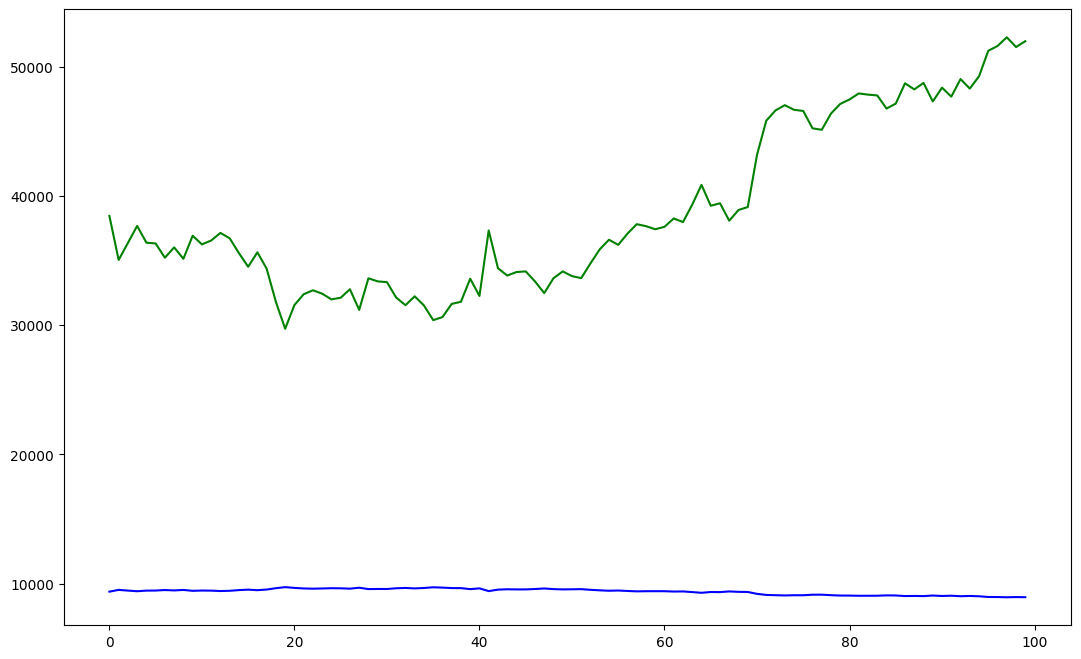

In [22]:
# Testing the model

with torch.no_grad():
    preds = []
    true = []
    for batch_x, batch_y in test_loader:
        batch_x = batch_x.cuda()
        batch_y = batch_y.cuda()
        output = model(batch_x)
        # output = output.squeeze(1)
        preds.append(scaler.inverse_transform(output.detach().cpu().numpy()))
        true.append(scaler.inverse_transform(batch_y.detach().cpu().numpy()))
    preds = np.concatenate(preds)
    true = np.concatenate(true)

    mse = mean_squared_error(true, preds)
    mae = mean_absolute_error(true, preds)

    print(mse, mae)
    n = 500
    plt.figure(figsize=(13, 8))
    plt.plot(preds[::n], 'b', label='line 1')
    plt.plot(true[::n], 'g',  label='line 2')
    plt.show()

### Detrended data

In [ ]:
interval = 60*24*365
transformed_train = df1["Weighted_Price"].diff(interval)

scaler = MinMaxScaler((-1,1))
scaler.fit(transformed_train[interval+1:].to_numpy().reshape(-1, 1))
data = scaler.transform(transformed_train[interval+1:].to_numpy().reshape(-1, 1))

In [ ]:
train = bitcoin(data.squeeze()[:3700000], 5)
val = bitcoin(data.squeeze()[3700000:3750000], 5)
test = bitcoin(data.squeeze()[3750000:3800000], 5)

train_loader = DataLoader(train, batch_size=batch_size, shuffle=False, drop_last=True)
val_loader = DataLoader(val, batch_size=batch_size, shuffle=False, drop_last=True)
test_loader = DataLoader(test, batch_size=1, shuffle=False, drop_last=True)

In [ ]:
dataset_iter = iter(train_loader)
temp = next(dataset_iter)
features, labels = temp
print(features.shape, labels.shape)

In [ ]:
input_shape = 5
model = RNNForecasting(input_shape, hidden_shape, 1, num_layers=3).cuda()

In [ ]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

epoch_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 5, gamma=0.9)

In [ ]:
# Training
l1_weight = 0.01
l2_weight = 0.01
for i in range(epochs):
    mse_train = 0
    for batch_x, batch_y in train_loader:
        batch_x = batch_x.cuda()
        batch_y = batch_y.cuda()
        # print(batch_x.dtype)
        optimizer.zero_grad()
        y_pred = model(batch_x)
        y_pred = y_pred.squeeze(1)
        l = criterion(y_pred, batch_y)

        # Using l1 regularization
        if l1:
            l1_parameters = []
            for parameter in model.parameters():
                l1_parameters.append(parameter.view(-1))
            L1 = l1_weight * model.compute_l1(torch.cat(l1_parameters))
            l += L1

        # Using l2 regularization
        if l2:
            l2_parameters = []
            for parameter in model.parameters():
                l2_parameters.append(parameter.view(-1))
            L1 = l2_weight * model.compute_l2(torch.cat(l2_parameters))
            l += L1

        l.backward()
        mse_train += l.item()*batch_x.shape[0]
        optimizer.step()
    if lr_decay:
        epoch_scheduler.step()
    with torch.no_grad():
        mse_val = 0
        preds = []
        true = []
        for batch_x, batch_y in val_loader:
            batch_x = batch_x.cuda()
            batch_y = batch_y.cuda()
            output = model(batch_x)
            output = output.squeeze(1)
            preds.append(output.detach().cpu().numpy())
            true.append(batch_y.detach().cpu().numpy())
            mse_val += criterion(output, batch_y).item()*batch_x.shape[0]
    preds = np.concatenate(preds)
    true = np.concatenate(true)

    print("Iter: ", i, "train: ", (mse_train/train.__len__())**0.5, "val: ", (mse_val/val.__len__())**0.5)

In [ ]:
# Testing the model

with torch.no_grad():
    preds = []
    true = []
    for batch_x, batch_y in test_loader:
        batch_x = batch_x.cuda()
        batch_y = batch_y.cuda()
        output = model(batch_x)
        # output = output.squeeze(1)
        preds.append(scaler.inverse_transform(output.detach().cpu().numpy()))
        true.append(scaler.inverse_transform(batch_y.detach().cpu().numpy()))
    preds = np.concatenate(preds)
    true = np.concatenate(true)

In [ ]:
true = true + data.squeeze()[3750000-(60*24*365):3800000-(60*24*365)]
preds = preds + data.squeeze()[3750000-(60*24*365):3800000-(60*24*365)]

mse = mean_squared_error(true, preds)
mae = mean_absolute_error(true, preds)

print(mse, mae)
n = 250
plt.figure(figsize=(8, 6))
plt.plot(preds[::n], 'b', label='line 1')
plt.plot(true[::n], 'g',  label='line 2')
plt.show()